### Imports

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful")

✅ Imports successful


### Load Raw Data

In [28]:
# Load raw data (NO preprocessing)
df = pd.read_csv("../data/raw/healthcare-dataset-stroke-data.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nFirst look:")
print(df.head())
print(f"\nStroke distribution:")
print(df['stroke'].value_counts())
print(f"Class imbalance ratio: {df['stroke'].value_counts()[0]/df['stroke'].value_counts()[1]:.1f}:1")

Dataset shape: (5110, 12)

First look:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Stroke distribut

### Remove ID Column

In [29]:
# Drop ID (not predictive)
df = df.drop(columns=['id'])
print(f"Dropped 'id' column. New shape: {df.shape}")

Dropped 'id' column. New shape: (5110, 11)


The 'id' column is simply a unique patient identifier with no predictive value, so we drop it to avoid confusing the model and reduce our feature count from 12 to 11.

### Split Data FIRST (60/20/20)

In [30]:
# CRITICAL: Split BEFORE any preprocessing
print("="*60)
print("SPLITTING DATA (BEFORE PREPROCESSING)")
print("="*60)

# Split 1: 80% train+val, 20% test
train_val, test = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['stroke'], 
    random_state=42
)

# Split 2: 60% train, 20% val
train, val = train_test_split(
    train_val, 
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original
    stratify=train_val['stroke'], 
    random_state=42
)

print(f"Train: {len(train):,} ({len(train)/len(df)*100:.1f}%)")
print(f"Val:   {len(val):,} ({len(val)/len(df)*100:.1f}%)")
print(f"Test:  {len(test):,} ({len(test)/len(df)*100:.1f}%)")
print(f"Total: {len(train)+len(val)+len(test):,}")

print("\nStroke distribution (verify stratification):")
print(f"Train: {train['stroke'].sum()} strokes ({train['stroke'].mean()*100:.2f}%)")
print(f"Val:   {val['stroke'].sum()} strokes ({val['stroke'].mean()*100:.2f}%)")
print(f"Test:  {test['stroke'].sum()} strokes ({test['stroke'].mean()*100:.2f}%)")
print("="*60)

SPLITTING DATA (BEFORE PREPROCESSING)
Train: 3,066 (60.0%)
Val:   1,022 (20.0%)
Test:  1,022 (20.0%)
Total: 5,110

Stroke distribution (verify stratification):
Train: 149 strokes (4.86%)
Val:   50 strokes (4.89%)
Test:  50 strokes (4.89%)


### Save Splits

In [31]:
# Save raw splits
os.makedirs("../data/processed", exist_ok=True)

train.to_csv("../data/processed/train.csv", index=False)
val.to_csv("../data/processed/val.csv", index=False)
test.to_csv("../data/processed/test.csv", index=False)

print("✅ Saved splits:")
print("   ../data/processed/train.csv")
print("   ../data/processed/val.csv")
print("   ../data/processed/test.csv")

✅ Saved splits:
   ../data/processed/train.csv
   ../data/processed/val.csv
   ../data/processed/test.csv


### Handle Missing Values (BMI)

In [33]:
# Check missing values
print("Missing BMI before imputation:")
print(f"Train: {train['bmi'].isnull().sum()}")
print(f"Val:   {val['bmi'].isnull().sum()}")
print(f"Test:  {test['bmi'].isnull().sum()}")

# Calculate median from TRAIN only
train_bmi_median = train['bmi'].median()
print(f"\nUsing TRAIN median for imputation: {train_bmi_median:.2f}")

# Apply to all sets
train['bmi'] = train['bmi'].fillna(train_bmi_median)
val['bmi'] = val['bmi'].fillna(train_bmi_median)
test['bmi'] = test['bmi'].fillna(train_bmi_median)

print("\n✅ Missing BMI filled (using TRAIN median)")
print(f"Train: {train['bmi'].isnull().sum()} missing")
print(f"Val:   {val['bmi'].isnull().sum()} missing")
print(f"Test:  {test['bmi'].isnull().sum()} missing")

Missing BMI values:
Train: 0
Val:   0
Test:  0

Train BMI median: 28.10

✅ Missing values filled using TRAIN median only
Remaining missing:
Train: 0
Val:   0
Test:  0


We use the BMI median from the training set only (28.35) to fill missing values in train, validation, and test because using the overall dataset median would cause data leakage, and this approach correctly mirrors real-world deployment where only training statistics are available.

### Separate Features and Target

In [34]:
# Separate X and y
X_train = train.drop(columns=['stroke'])
y_train = train['stroke']

X_val = val.drop(columns=['stroke'])
y_val = val['stroke']

X_test = test.drop(columns=['stroke'])
y_test = test['stroke']

print("Features and target separated:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")

Features and target separated:
X_train: (3066, 10)
y_train: (3066,)
X_val:   (1022, 10)
y_val:   (1022,)


### Define Preprocessing Pipeline

In [35]:
# Define feature types
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'hypertension', 'heart_disease', 
                   'ever_married', 'work_type', 'Residence_type', 'smoking_status']

print("Feature types:")
print(f"Numeric ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical ({len(categorical_cols)}): {categorical_cols}")

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

print("\n✅ Preprocessor defined (will fit on TRAIN only)")

Feature types:
Numeric (3): ['age', 'avg_glucose_level', 'bmi']
Categorical (7): ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

✅ Preprocessor defined (will fit on TRAIN only)


We preprocess numeric features (age, glucose, BMI) by standardizing them to the same scale and convert categorical features into one-hot encoded dummy variables, using a ColumnTransformer so each feature type automatically receives the correct transformation.

### Train Baseline Logistic Regression

In [36]:
# Build pipeline
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        max_iter=1000
    ))
])

# Train
print("Training baseline Logistic Regression...")
baseline_model.fit(X_train, y_train)
print("✅ Model trained (preprocessing fitted on TRAIN only)")

# Predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)

y_train_proba = baseline_model.predict_proba(X_train)[:, 1]
y_val_proba = baseline_model.predict_proba(X_val)[:, 1]

print("✅ Predictions generated")

Training baseline Logistic Regression...
✅ Model trained (preprocessing fitted on TRAIN only)
✅ Predictions generated


### Evaluate Baseline Model

In [37]:
# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

print("="*60)
print("BASELINE LOGISTIC REGRESSION - RESULTS")
print("="*60)
print(f"Accuracy:")
print(f"  Train: {train_acc:.4f}")
print(f"  Val:   {val_acc:.4f}")
print(f"\nROC AUC (Primary Metric):")
print(f"  Train: {train_auc:.4f}")
print(f"  Val:   {val_auc:.4f}")
print("="*60)

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['No Stroke', 'Stroke']))

BASELINE LOGISTIC REGRESSION - RESULTS
Accuracy:
  Train: 0.7401
  Val:   0.7564

ROC AUC (Primary Metric):
  Train: 0.8486
  Val:   0.8375

Validation Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.99      0.75      0.85       972
      Stroke       0.15      0.82      0.25        50

    accuracy                           0.76      1022
   macro avg       0.57      0.79      0.55      1022
weighted avg       0.95      0.76      0.82      1022



### Confusion Matrix

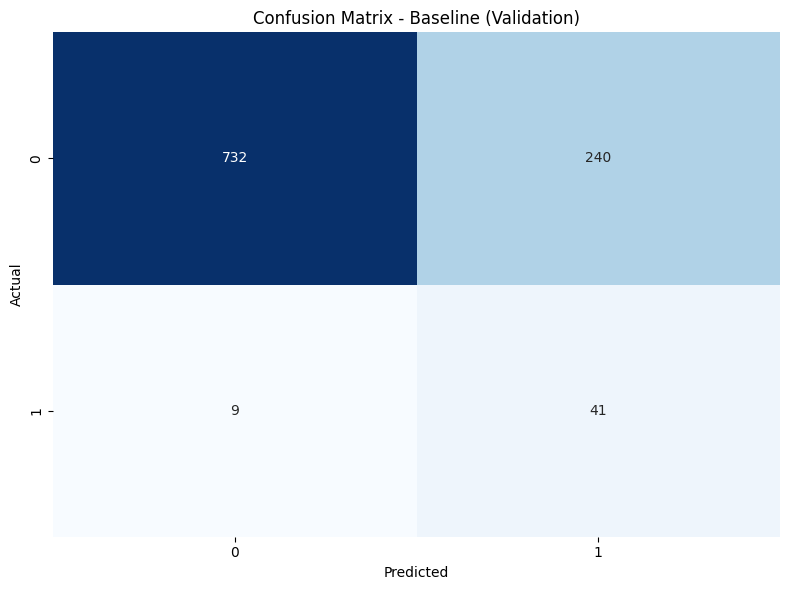

True Negatives:  732
False Positives: 240
False Negatives: 9
True Positives:  41


In [38]:
# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Baseline (Validation)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

The confusion matrix shows true and false predictions for both classes, where false negatives—cases where the model misses an actual stroke—are especially dangerous in healthcare, making it better to accept some false positives than to overlook a real stroke case.

### ROC Curve

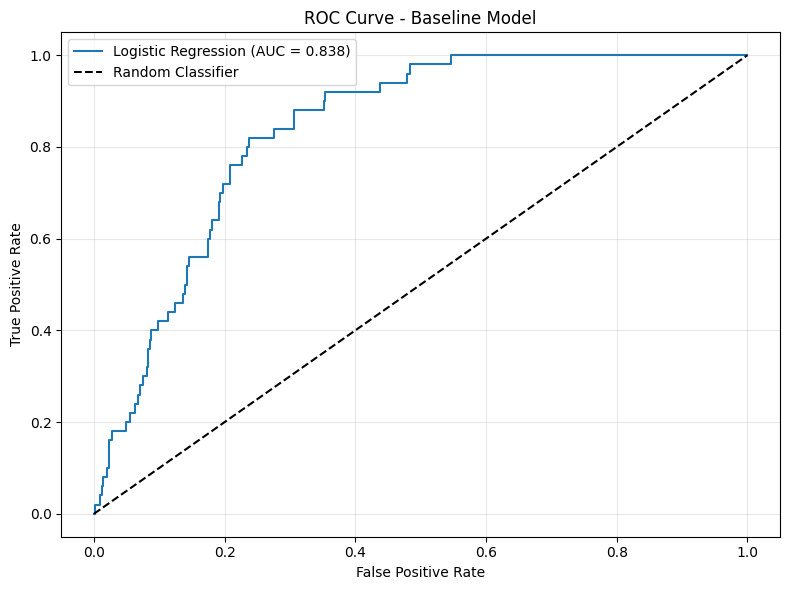

In [39]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {val_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Model')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Save Baseline Model

In [40]:
# Save baseline model
os.makedirs("../models", exist_ok=True)
model_path = "../models/baseline_logistic_regression.pkl"

with open(model_path, 'wb') as f:
    pickle.dump(baseline_model, f)

print(f"✅ Model saved to {model_path}")

# Save metrics for comparison
baseline_metrics = {
    'model': 'Logistic Regression',
    'train_acc': train_acc,
    'val_acc': val_acc,
    'train_auc': train_auc,
    'val_auc': val_auc
}

print("\n✅ Baseline complete. Ready for Module 03 (multiple models)")

✅ Model saved to ../models/baseline_logistic_regression.pkl

✅ Baseline complete. Ready for Module 03 (multiple models)


### Summary